In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model


In [ ]:
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(128 * 7 * 7, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))
    return model


In [ ]:
def build_discriminator(input_shape=(28, 28, 1)):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=input_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model


In [ ]:
discriminator = build_discriminator()
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
latent_dim = 100
generator = build_generator(latent_dim)

# Create GAN model
discriminator.trainable = False
gan_input = Input(shape=(latent_dim,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)
gan = Model(gan_input, gan_output)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
def train_gan(gan, generator, discriminator, epochs=1000, batch_size=64, latent_dim=100, plot_interval=100):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=-1)

    half_batch = batch_size // 2

    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_images = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_images = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_images, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((half_batch, 1)))

        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Print the progress
        print(f"Epoch {epoch+1}, D Loss: {d_loss[0]}, D Accuracy: {d_loss[1]*100}, G Loss: {g_loss}")

        # Plot generated images
        if (epoch + 1) % plot_interval == 0:
            plot_generated_images(epoch, generator, latent_dim)


In [ ]:
def plot_generated_images(epoch, generator, latent_dim, examples=25, dim=(5, 5), figsize=(10, 10)):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"gan_generated_image_epoch_{epoch+1}.png")
    plt.show()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1, D Loss: 0.7246078252792358, D Accuracy: 32.03125, G Loss: [array(0.7134625, dtype=float32), array(0.7134625, dtype=float32), array(0.546875, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


Epoch 2, D Loss: 0.7178120613098145, D Accuracy: 37.76041865348816, G Loss: [array(0.71428907, dtype=float32), array(0.71428907, dtype=float32), array(0.390625, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 3, D Loss: 0.7179199457168579, D Accuracy: 29.739582538604736, G Loss: [array(0.7158376, dtype=float32), array(0.7158376, dtype=float32), array(0.2760417, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Epoch 4, D Loss: 0.7192351222038269, D Accuracy: 22.57254421710968, G Loss: [array(0.7177225, dtype=float32), array(0.7177225, dtype=float32), array(0.21484375, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Epoch 5, D Loss: 0.7188652753829956, D Accuracy: 18.958333134651184, G Loss: [array(0.7178133, dtype=float32), array(0.7178133, dtype=float32), array(0.18125, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 6, D Loss: 0.7194896936416626, D Accuracy: 15.790720283985138, G Loss: [array(0.7187509, dtype=float32), array(0.7187509, dtype=float32)

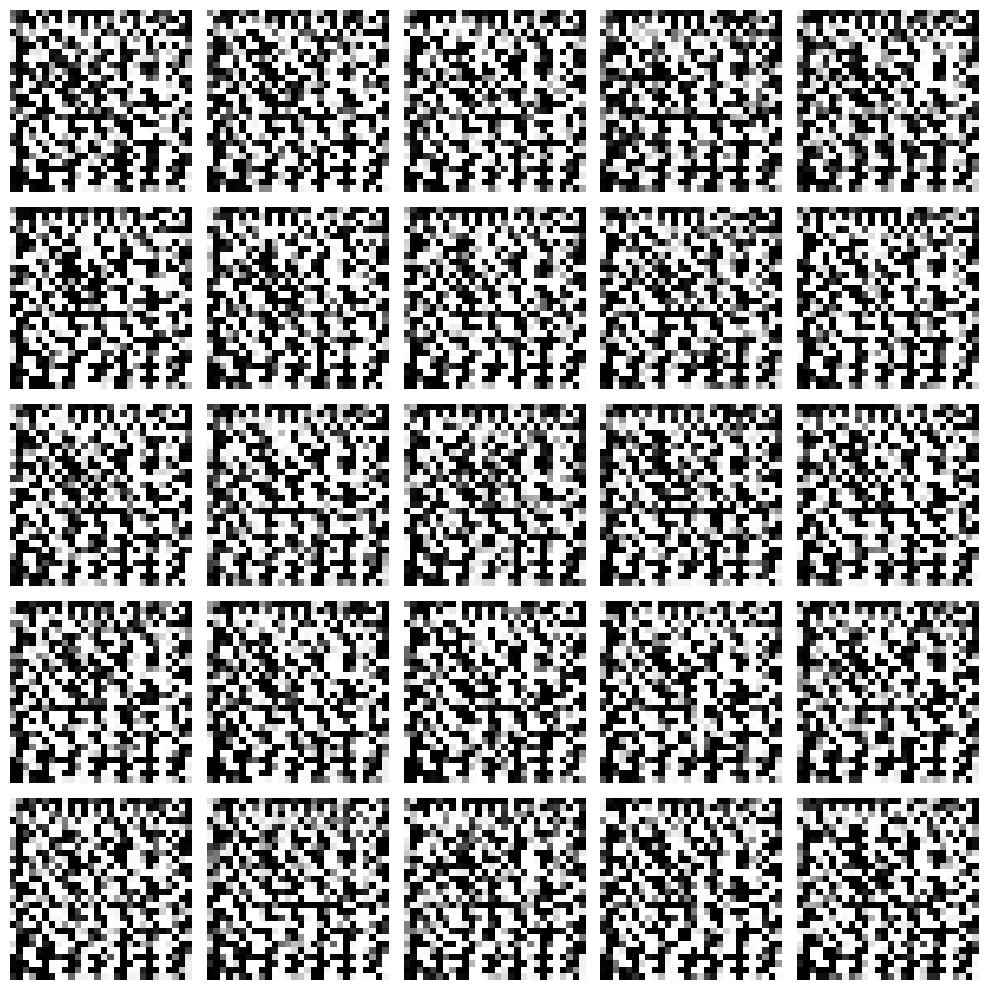

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 101, D Loss: 0.923516035079956, D Accuracy: 1.8455447629094124, G Loss: [array(0.9247768, dtype=float32), array(0.9247768, dtype=float32), array(0.01840965, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 102, D Loss: 0.9251191020011902, D Accuracy: 1.8274066969752312, G Loss: [array(0.92637926, dtype=float32), array(0.92637926, dtype=float32), array(0.01822917, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 103, D Loss: 0.926687479019165, D Accuracy: 1.8096214160323143, G Loss: [array(0.92792195, dtype=float32), array(0.92792195, dtype=float32), array(0.01805218, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 104, D Loss: 0.9282801747322083, D Accuracy: 1.7921790480613708, G Loss: [array(0.9295189, dtype=float32), array(0.9295189, dtype=float32), array(0.01787861, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 105, D Loss: 0.9298868179321289, D Accuracy: 1.7750699073076248, G Loss: [array(0.

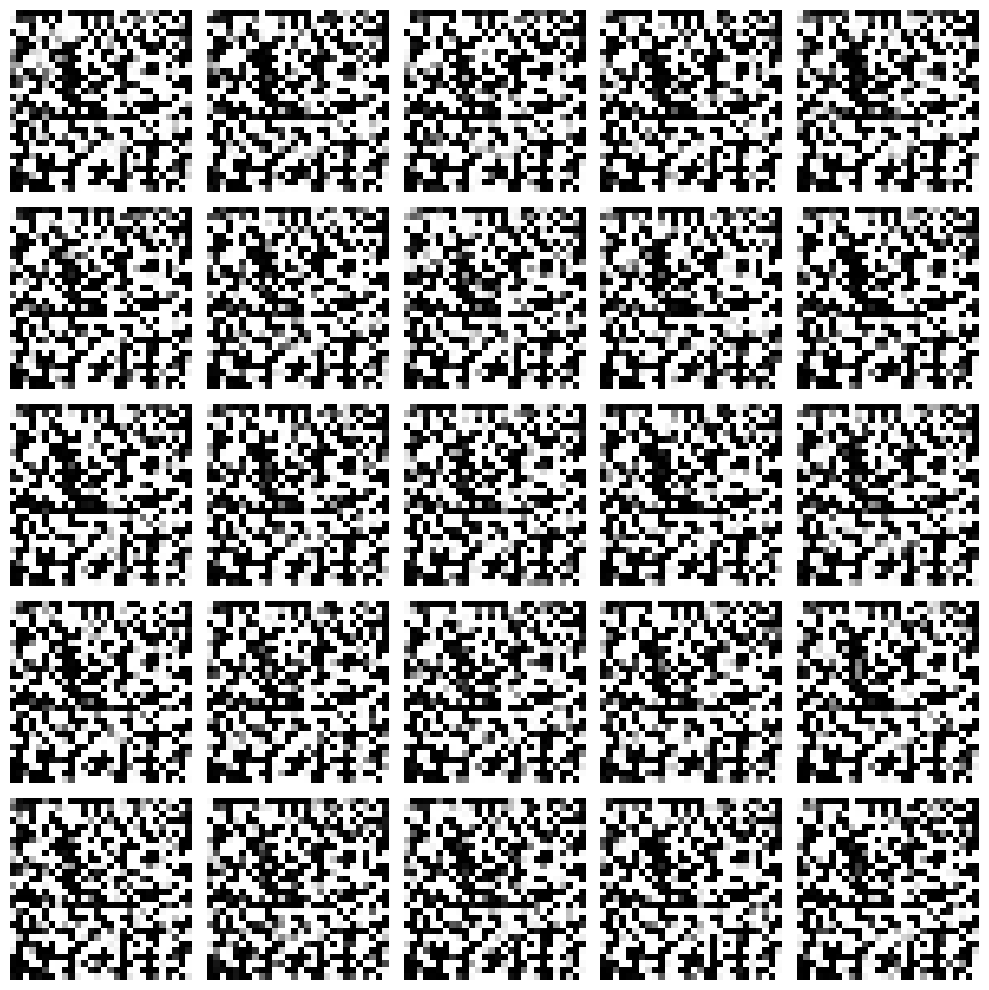

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 201, D Loss: 1.0454633235931396, D Accuracy: 1.3932150788605213, G Loss: [array(1.0463009, dtype=float32), array(1.0463009, dtype=float32), array(0.0139148, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 202, D Loss: 1.0463824272155762, D Accuracy: 1.386309415102005, G Loss: [array(1.0472153, dtype=float32), array(1.0472153, dtype=float32), array(0.01384592, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 203, D Loss: 1.0473103523254395, D Accuracy: 1.3871785253286362, G Loss: [array(1.0481418, dtype=float32), array(1.0481418, dtype=float32), array(0.01385468, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 204, D Loss: 1.0482065677642822, D Accuracy: 1.3803701847791672, G Loss: [array(1.0490365, dtype=float32), array(1.0490365, dtype=float32), array(0.01378676, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 205, D Loss: 1.0491130352020264, D Accuracy: 1.3736284337937832, G Loss: [array(1.0499

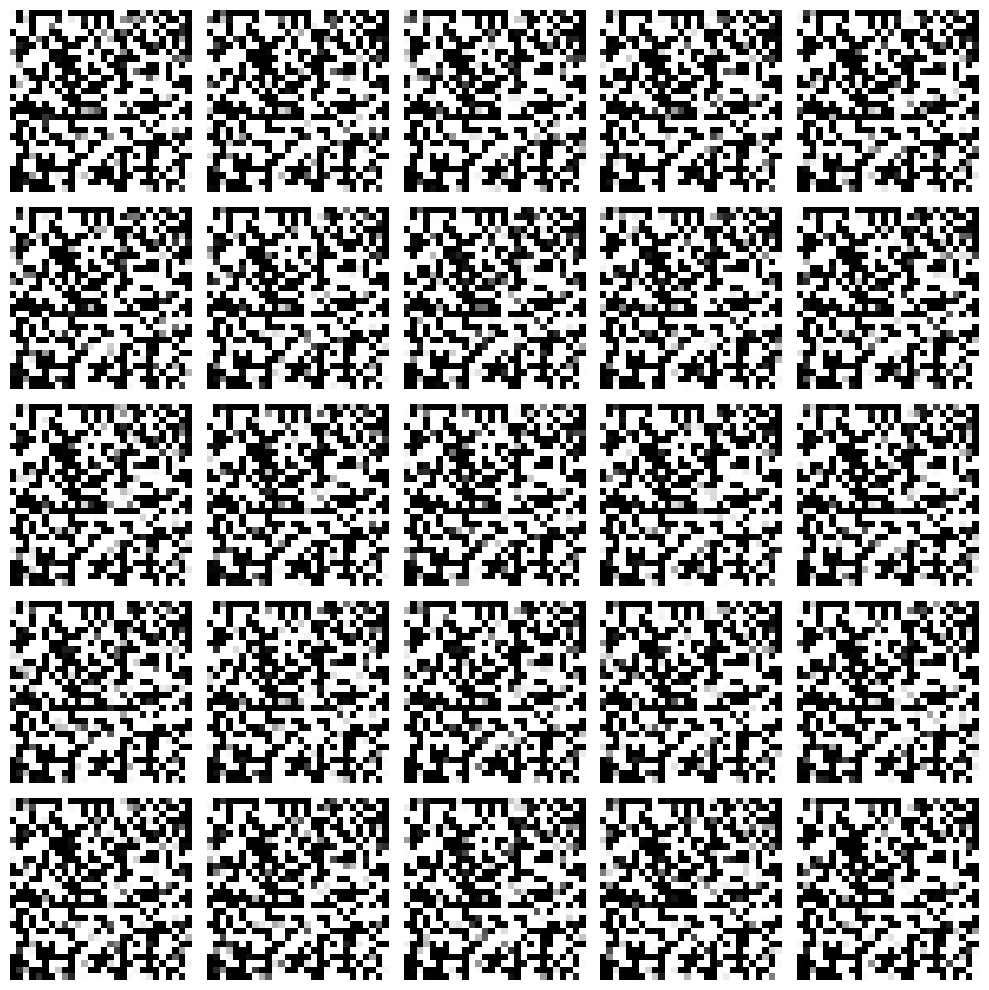

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 301, D Loss: 1.115776538848877, D Accuracy: 1.189734786748886, G Loss: [array(1.1163452, dtype=float32), array(1.1163452, dtype=float32), array(0.01188746, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 302, D Loss: 1.1162887811660767, D Accuracy: 1.1857920326292515, G Loss: [array(1.1168565, dtype=float32), array(1.1168565, dtype=float32), array(0.0118481, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Epoch 303, D Loss: 1.1168009042739868, D Accuracy: 1.1870363727211952, G Loss: [array(1.1173646, dtype=float32), array(1.1173646, dtype=float32), array(0.01186056, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 304, D Loss: 1.117314338684082, D Accuracy: 1.1882724240422249, G Loss: [array(1.1178752, dtype=float32), array(1.1178752, dtype=float32), array(0.01187294, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 305, D Loss: 1.1178112030029297, D Accuracy: 1.1895004659891129, G Loss: [array(1.118371

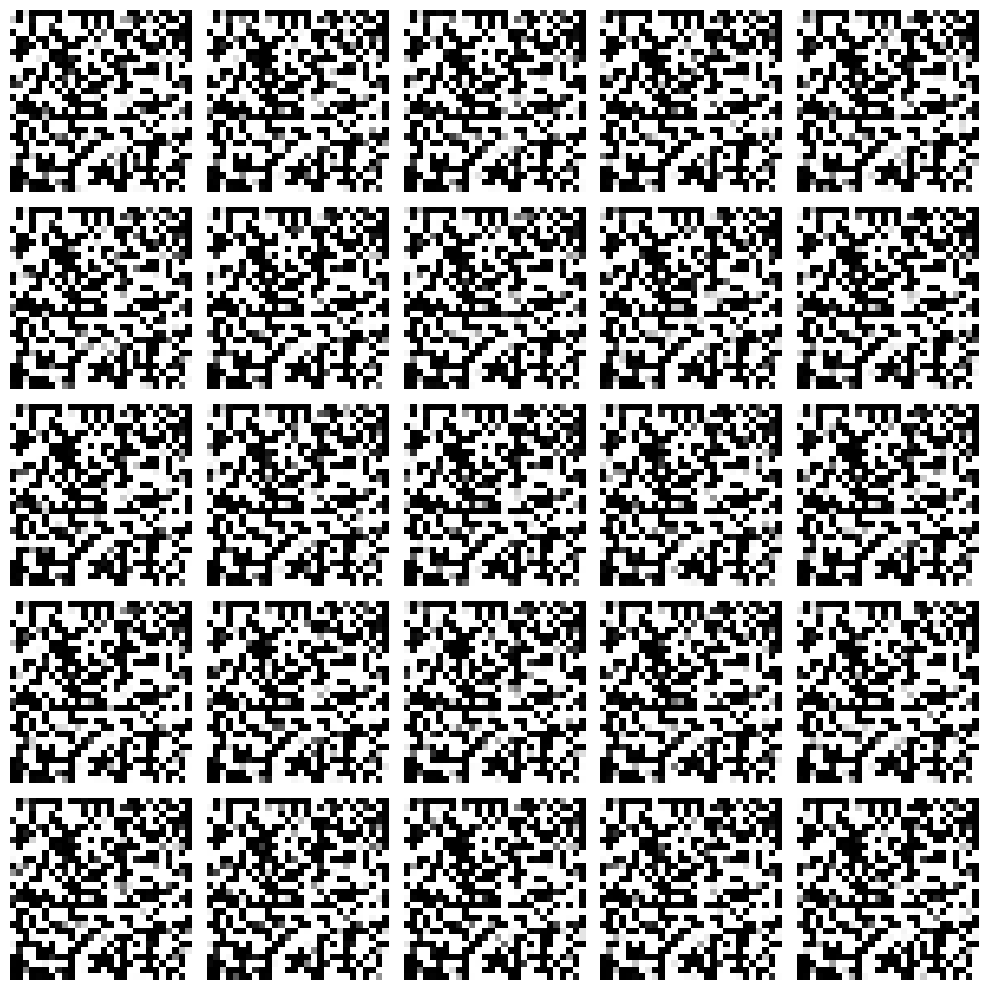

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Epoch 401, D Loss: 1.1557302474975586, D Accuracy: 1.165783405303955, G Loss: [array(1.1561455, dtype=float32), array(1.1561455, dtype=float32), array(0.01165056, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Epoch 402, D Loss: 1.156040906906128, D Accuracy: 1.1706599965691566, G Loss: [array(1.1564542, dtype=float32), array(1.1564542, dtype=float32), array(0.01169932, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 403, D Loss: 1.1563645601272583, D Accuracy: 1.1677533388137817, G Loss: [array(1.1567771, dtype=float32), array(1.1567771, dtype=float32), array(0.01167028, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 404, D Loss: 1.156674861907959, D Accuracy: 1.168731041252613, G Loss: [array(1.1570868, dtype=float32), array(1.1570868, dtype=float32), array(0.01168007, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 405, D Loss: 1.1569828987121582, D Accuracy: 1.1697039939463139, G Loss: [array(1.157394

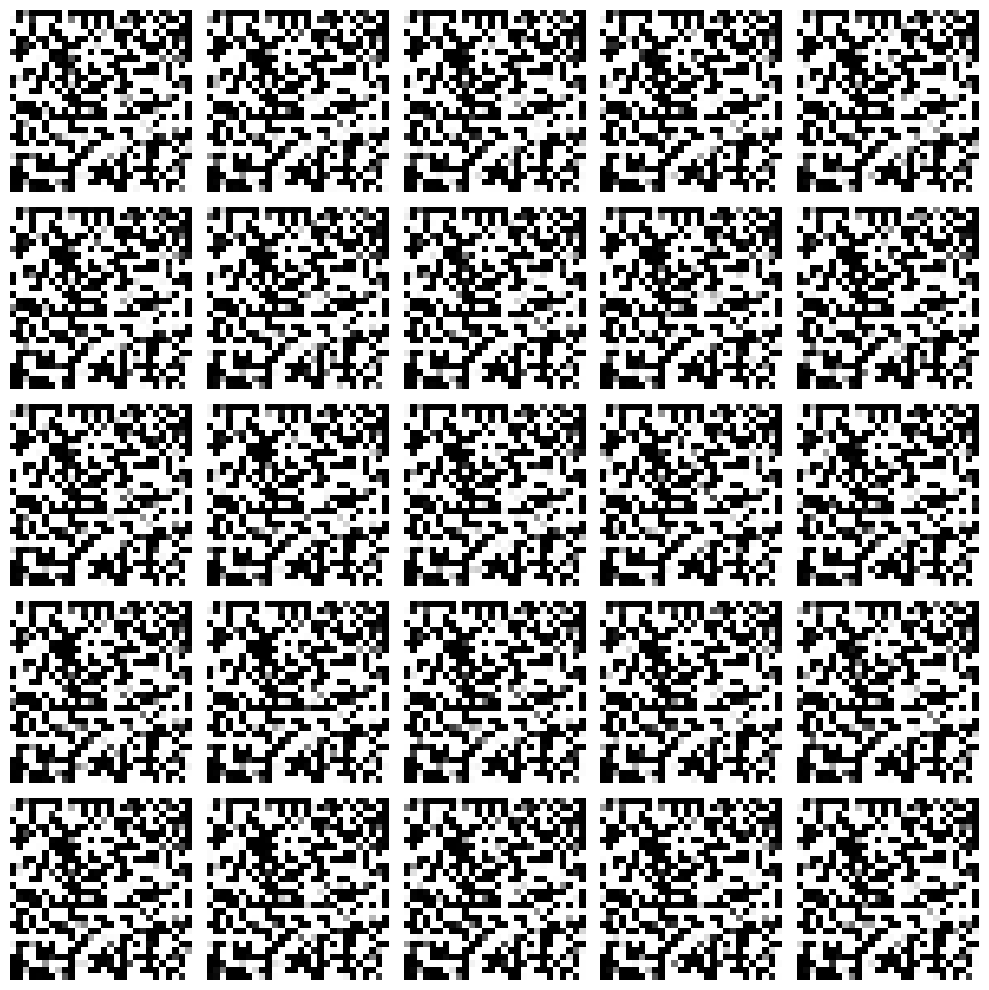

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 501, D Loss: 1.1815662384033203, D Accuracy: 1.1014729738235474, G Loss: [array(1.1818928, dtype=float32), array(1.1818928, dtype=float32), array(0.01100923, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 502, D Loss: 1.181783676147461, D Accuracy: 1.102392002940178, G Loss: [array(1.1821095, dtype=float32), array(1.1821095, dtype=float32), array(0.01101843, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 503, D Loss: 1.1819978952407837, D Accuracy: 1.103307120501995, G Loss: [array(1.1823235, dtype=float32), array(1.1823235, dtype=float32), array(0.01102759, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 504, D Loss: 1.1822147369384766, D Accuracy: 1.1042186990380287, G Loss: [array(1.1825389, dtype=float32), array(1.1825389, dtype=float32), array(0.01103671, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 505, D Loss: 1.1824183464050293, D Accuracy: 1.102031022310257, G Loss: [array(1.182741

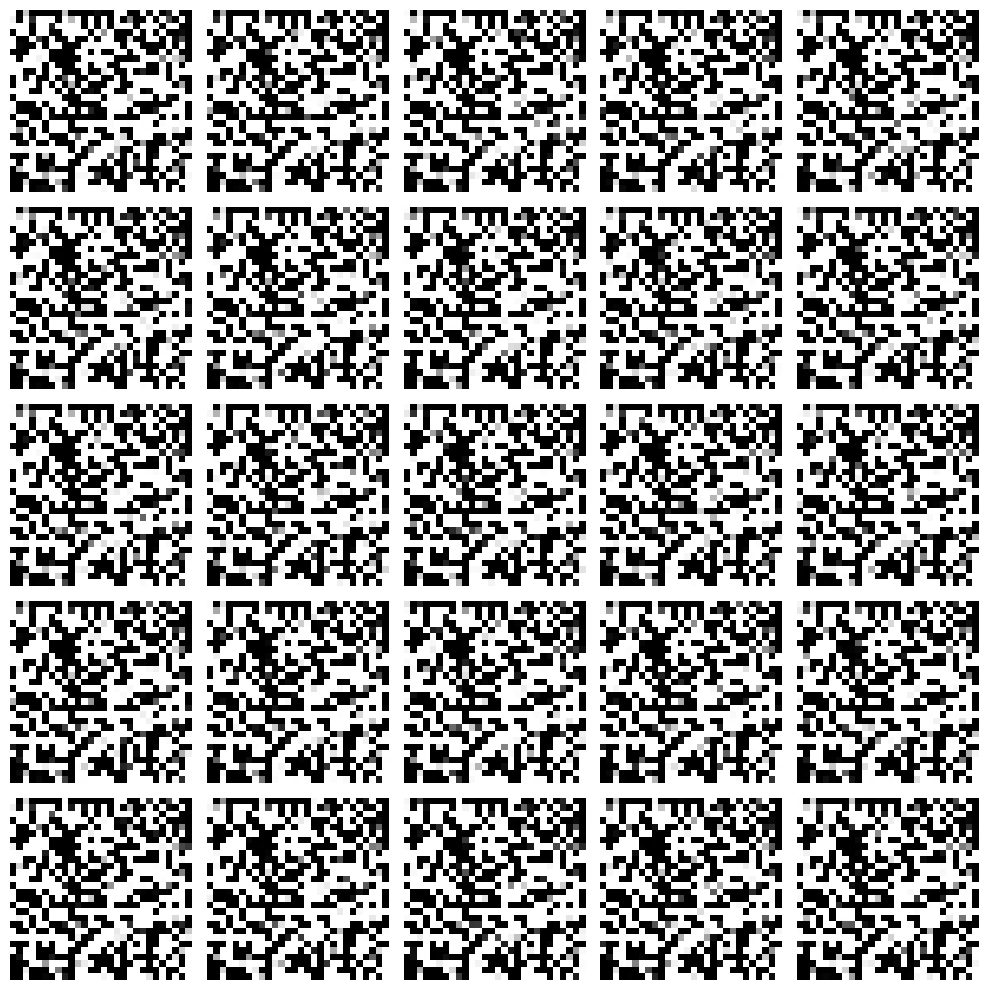

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 601, D Loss: 1.1998767852783203, D Accuracy: 1.061173714697361, G Loss: [array(1.2001454, dtype=float32), array(1.2001454, dtype=float32), array(0.01060732, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 602, D Loss: 1.2000300884246826, D Accuracy: 1.062006875872612, G Loss: [array(1.200298, dtype=float32), array(1.200298, dtype=float32), array(0.01061566, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 603, D Loss: 1.2001848220825195, D Accuracy: 1.0628372430801392, G Loss: [array(1.2004517, dtype=float32), array(1.2004517, dtype=float32), array(0.01062396, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 604, D Loss: 1.2003366947174072, D Accuracy: 1.061076857149601, G Loss: [array(1.2006037, dtype=float32), array(1.2006037, dtype=float32), array(0.01060637, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 605, D Loss: 1.2004905939102173, D Accuracy: 1.0593222454190254, G Loss: [array(1.2007569

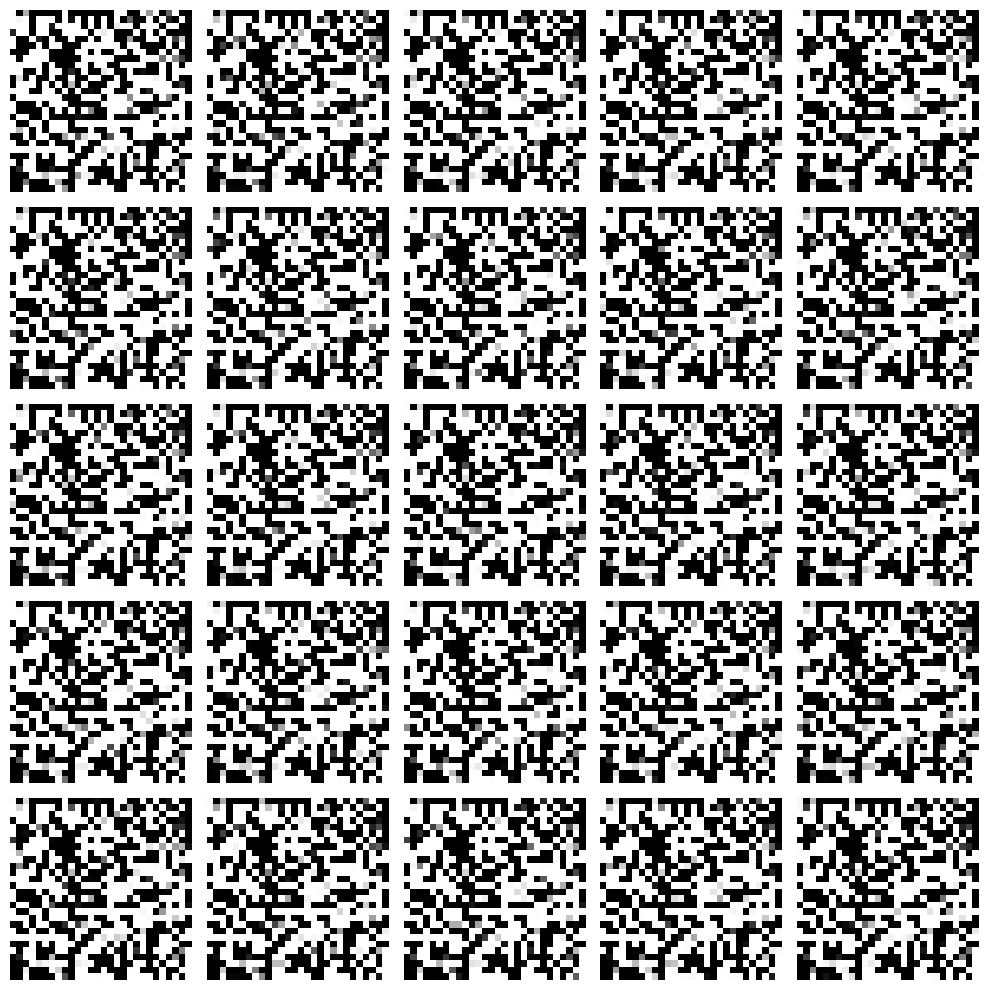

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 701, D Loss: 1.213340163230896, D Accuracy: 1.0479845106601715, G Loss: [array(1.2135668, dtype=float32), array(1.2135668, dtype=float32), array(0.01047611, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 702, D Loss: 1.2134559154510498, D Accuracy: 1.0487176477909088, G Loss: [array(1.2136824, dtype=float32), array(1.2136824, dtype=float32), array(0.01048344, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 703, D Loss: 1.2135733366012573, D Accuracy: 1.047225296497345, G Loss: [array(1.2137995, dtype=float32), array(1.2137995, dtype=float32), array(0.01046853, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 704, D Loss: 1.213688611984253, D Accuracy: 1.0479575023055077, G Loss: [array(1.2139145, dtype=float32), array(1.2139145, dtype=float32), array(0.01047585, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 705, D Loss: 1.213808298110962, D Accuracy: 1.0464705526828766, G Loss: [array(1.214033

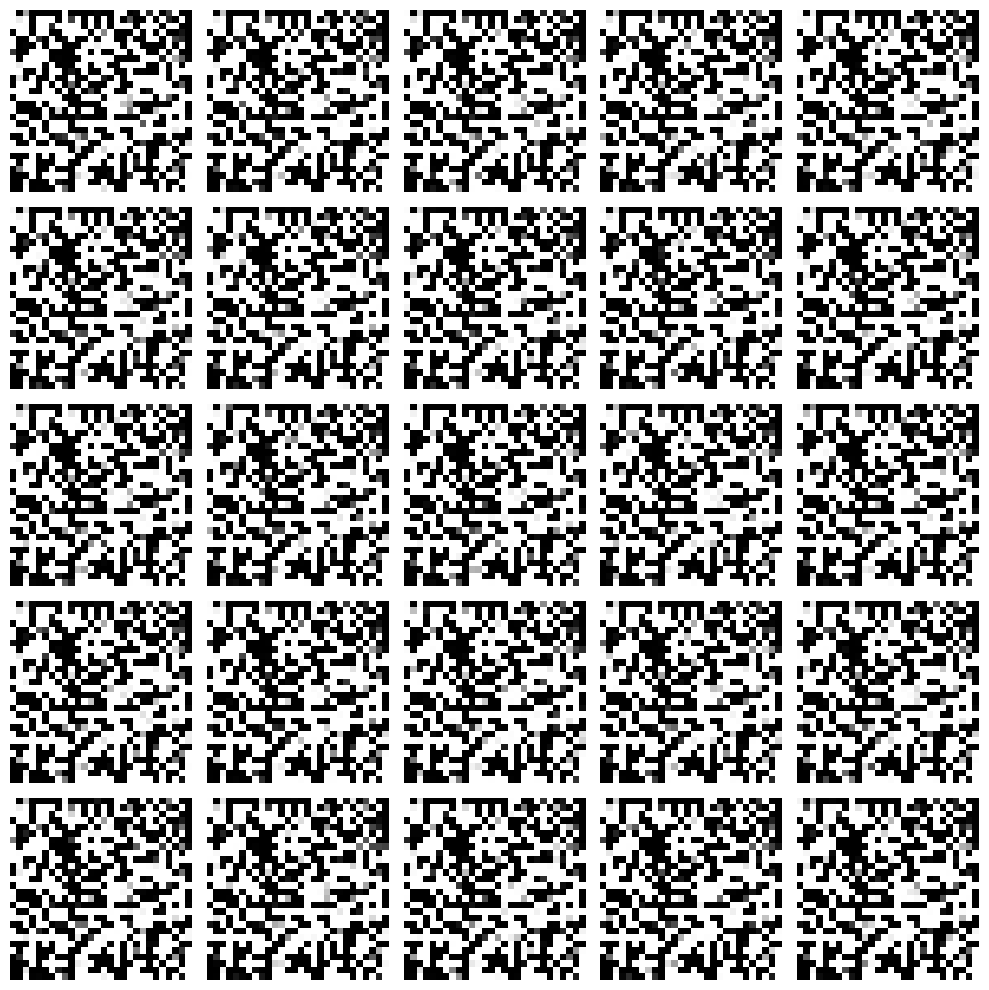

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 801, D Loss: 1.223771095275879, D Accuracy: 1.0283328592777252, G Loss: [array(1.223968, dtype=float32), array(1.223968, dtype=float32), array(0.01028012, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Epoch 802, D Loss: 1.223868489265442, D Accuracy: 1.0270502418279648, G Loss: [array(1.2240655, dtype=float32), array(1.2240655, dtype=float32), array(0.0102673, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 803, D Loss: 1.2239634990692139, D Accuracy: 1.0257708840072155, G Loss: [array(1.2241601, dtype=float32), array(1.2241601, dtype=float32), array(0.01025451, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Epoch 804, D Loss: 1.2240571975708008, D Accuracy: 1.02449469268322, G Loss: [array(1.2242535, dtype=float32), array(1.2242535, dtype=float32), array(0.01024176, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 805, D Loss: 1.2241487503051758, D Accuracy: 1.0232215747237206, G Loss: [array(1.2243446, 

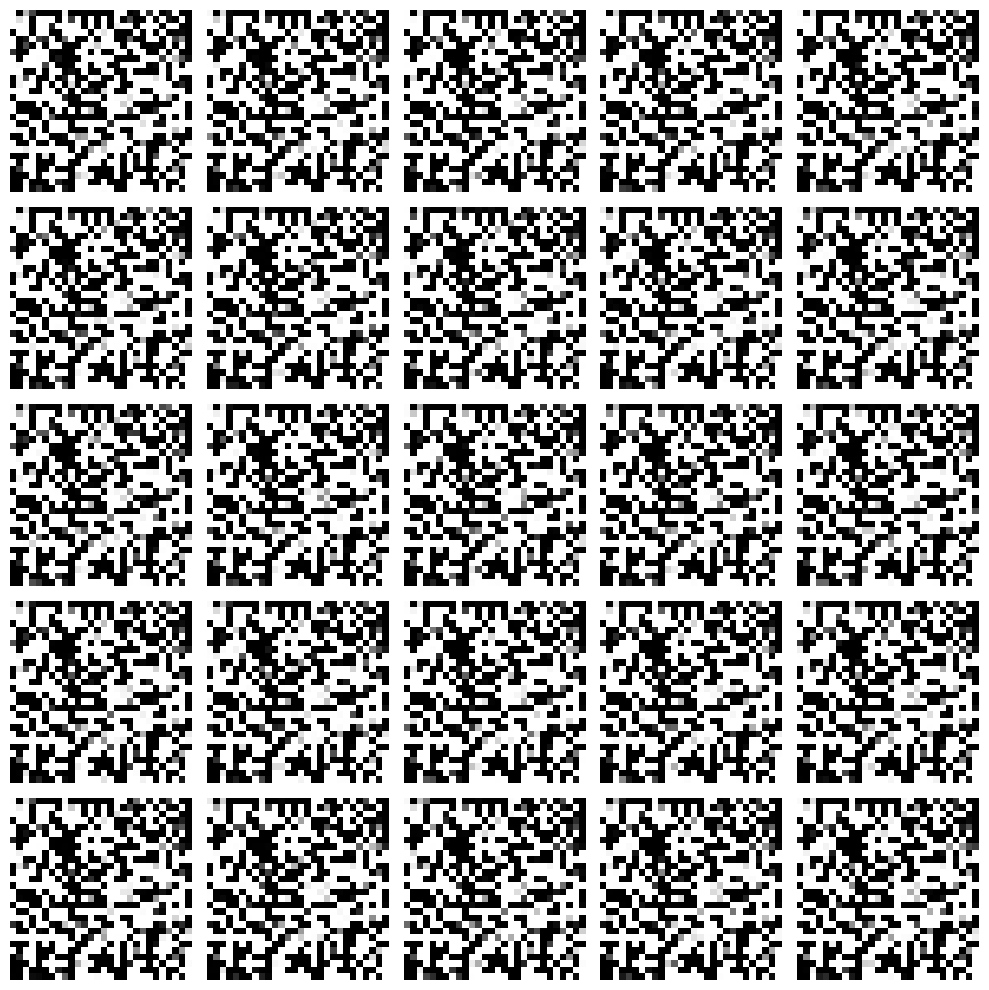

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Epoch 901, D Loss: 1.232135534286499, D Accuracy: 1.037330087274313, G Loss: [array(1.2323097, dtype=float32), array(1.2323097, dtype=float32), array(0.01037042, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Epoch 902, D Loss: 1.2322149276733398, D Accuracy: 1.0361798107624054, G Loss: [array(1.2323887, dtype=float32), array(1.2323887, dtype=float32), array(0.01035892, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 903, D Loss: 1.2322907447814941, D Accuracy: 1.0350318625569344, G Loss: [array(1.232464, dtype=float32), array(1.232464, dtype=float32), array(0.01034745, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Epoch 904, D Loss: 1.2323641777038574, D Accuracy: 1.0338867083191872, G Loss: [array(1.2325376, dtype=float32), array(1.2325376, dtype=float32), array(0.01033601, dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Epoch 905, D Loss: 1.2324409484863281, D Accuracy: 1.034471020102501, G Loss: [array(1.2326139

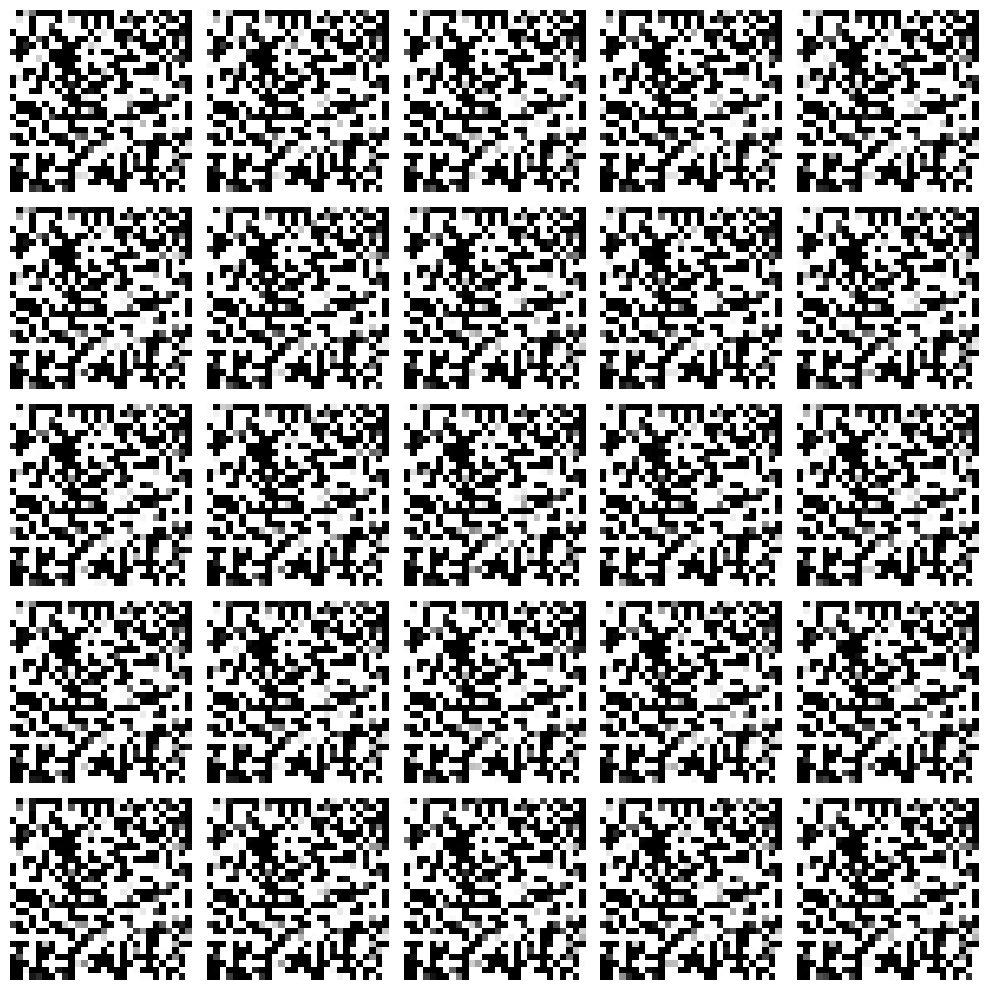

In [ ]:
train_gan(gan, generator, discriminator, epochs=1000, batch_size=64, latent_dim=100, plot_interval=100)
